In [1]:
# Set project directory
import os
import sys


def project_dir():
    notebook_path = %pwd
    repo_name = "nsl_kdd"
    repo_folder = notebook_path.split(repo_name)[0]
    return os.path.join(repo_folder, repo_name)


pwd = os.getenv("PWD", project_dir())
os.environ["PWD"] = pwd
sys.path.append(pwd)

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import time
from data_utils import *
import umap


from data_utils import load_train_test_data
from src.feature_extraction import CategoricalExtractor

import warnings
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)

# Load data

In [3]:
(X_train, X_test, Y_train, Y_test), attack_classes = load_train_test_data(pwd=pwd, return_classes=True, standardize=True, norm=False, include_categorical=True)

In [4]:
X = np.vstack([X_train, X_test])
Y = np.vstack([Y_train, Y_test])
nsl_lables = np.argmax(Y[:], axis=1)

# Utils

In [5]:
extractor = CategoricalExtractor(16, root=pwd)

Metal device set to: Apple M1 Pro


2022-06-15 19:26:02.379915: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-15 19:26:02.380213: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
extracted_features = extractor.extract_features(X)

2022-06-15 19:26:02.666889: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-15 19:26:02.721752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [7]:
extracted_features.shape

(148517, 16)

In [8]:
RUN_ALGORITHMS = False

In [16]:
def plot_2d(X_list, y, subtitles, title, figsize=(24, 7), labels=None, bbox_shift=1.15, s=15, rows=1, cols=3):
    plt.figure(figsize=figsize)
    for i, X in enumerate(X_list):
        plt.subplot(rows, cols, i + 1)
        scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='tab10', s=s)
        plt.title(subtitles[i])

    handles, classes = scatter.legend_elements()
    if labels is not None:
        classes = labels
    plt.legend(handles, classes, bbox_to_anchor=(bbox_shift, 1.02), loc='upper right')
    plt.tight_layout()
#     plt.suptitle(title)
    plt.savefig(f"{title}_with_categorical_extracted_bn16.png")

# TSNE

In [17]:
titles_tsne_nsl = [
    #'perplexity=5',
    'perplexity=30',
    'perplexity=80',
    'perplexity=120',
    #'perplexity=160'
]

if RUN_ALGORITHMS:
    tsne_list_nsl = [
        #TSNE(perplexity=5, n_components=2, random_state=42),
        TSNE(perplexity=30, n_components=2, random_state=42),
        TSNE(perplexity=80, n_components=2, random_state=42),
        TSNE(perplexity=120, n_components=2, random_state=42),
        #TSNE(perplexity=160, n_components=2, random_state=42)
    ]

    X_nsl_tsne = []
    for i, tsne in enumerate(tsne_list_nsl):
        print(f'Starting {titles_tsne_nsl[i]}, ', end='')
        X_nsl_tsne.append(run_and_measure(tsne.fit_transform, extracted_features))

    np.save(pwd + '/data/saved_X/X_nsl_tsne_with_categorical_extracted_bn16.npy', np.array(X_nsl_tsne))

else:
    X_nsl_tsne = np.load(pwd + '/data/saved_X/X_nsl_tsne_with_categorical_extracted_bn16.npy')

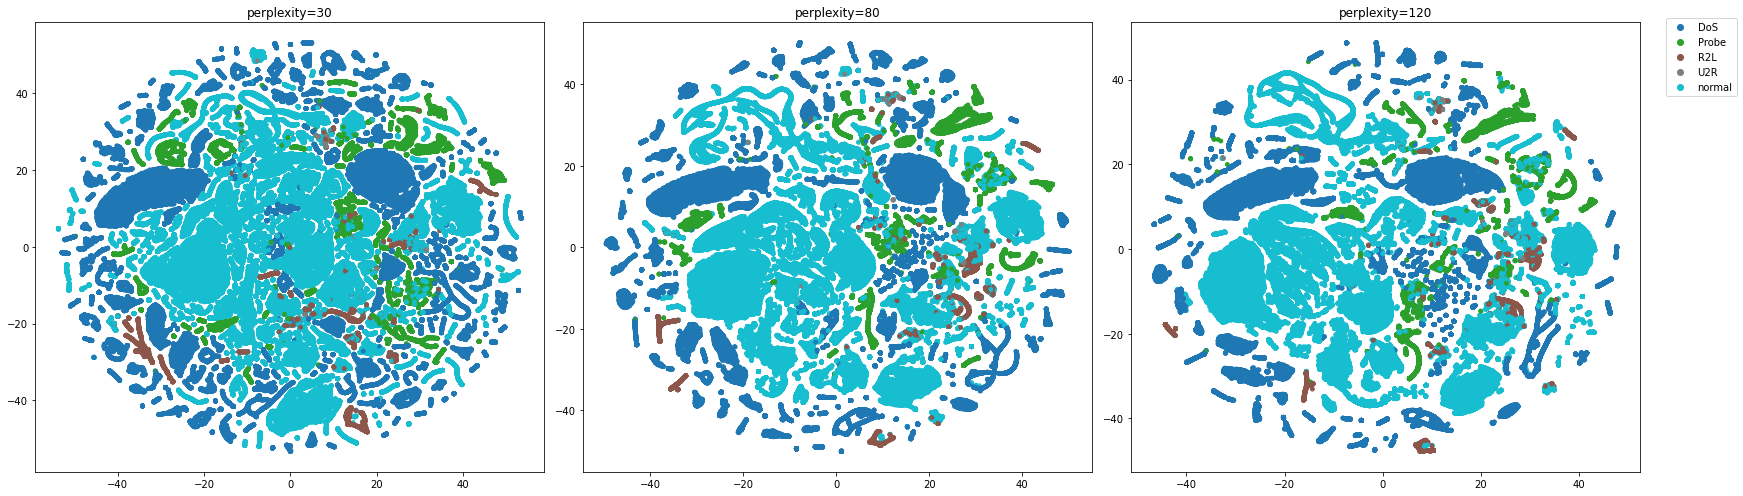

In [18]:
plot_2d(X_nsl_tsne[1:4], nsl_lables, titles_tsne_nsl, 'NSL t-SNE', labels=attack_classes, bbox_shift=1.2, rows=1, figsize=(24, 7))

# UMAP

In [10]:
titles_umap_nsl = [
    'n_neighbors=15, min_dist=0.4',
    'n_neighbors=60, min_dist=0.6',
    'n_neighbors=100, min_dist=0.8',
]

if RUN_ALGORITHMS:
    umap_list_nsl = [
        umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.4, random_state=42),
        umap.UMAP(n_neighbors=60, n_components=2, min_dist=0.6, random_state=42),
        umap.UMAP(n_neighbors=100, n_components=2, min_dist=0.8, random_state=42),
    ]

    X_nsl_umap = []
    for i, umap_model in enumerate(umap_list_nsl):
        print(f'Starting {titles_umap_nsl[i]}, ', end='')
        X_nsl_umap.append(run_and_measure(umap_model.fit_transform, X))

    np.save(pwd + '/data/saved_X/X_nsl_umap_with_categorical_extracted_bn16.npy', np.array(X_nsl_umap))

else:
    X_nsl_umap = np.load(pwd + '/data/saved_X/X_nsl_umap_with_categorical_extracted_bn16.npy')

Starting n_neighbors=15, min_dist=0.4, 176.21 s
Starting n_neighbors=60, min_dist=0.6, 279.43 s
Starting n_neighbors=100, min_dist=0.8, 261.73 s


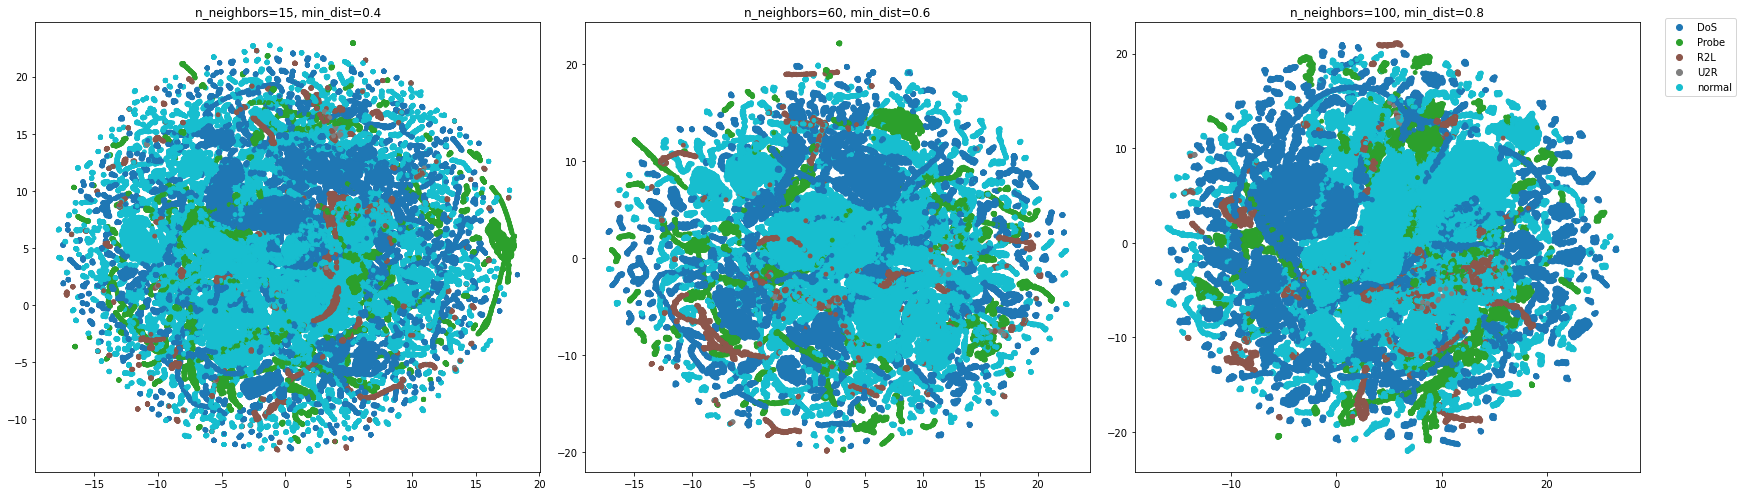

In [11]:
plot_2d(X_nsl_umap, nsl_lables, titles_umap_nsl, 'NSL UMAP', labels=attack_classes, bbox_shift=1.2, rows=1, figsize=(24, 7))

In [14]:
titles_umap_nsl = [
    'n_neighbors=15',
    'n_neighbors=60',
    'n_neighbors=100',
]

if RUN_ALGORITHMS:
    umap_list_nsl = [
        umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.4, random_state=42),
        umap.UMAP(n_neighbors=60, n_components=2, min_dist=0.4, random_state=42),
        umap.UMAP(n_neighbors=100, n_components=2, min_dist=0.4, random_state=42),
    ]

    X_nsl_umap = []
    for i, umap_model in enumerate(umap_list_nsl):
        print(f'Starting {titles_umap_nsl[i]}, ', end='')
        X_nsl_umap.append(run_and_measure(umap_model.fit_transform, X[:20000]))

    np.save(pwd + '/data/saved_X/X_nsl_umap_with_categorical_extracted_bn16_20000.npy', np.array(X_nsl_umap))

else:
    X_nsl_umap = np.load(pwd + '/data/saved_X/X_nsl_umap_with_categorical_extracted_bn16_20000.npy')

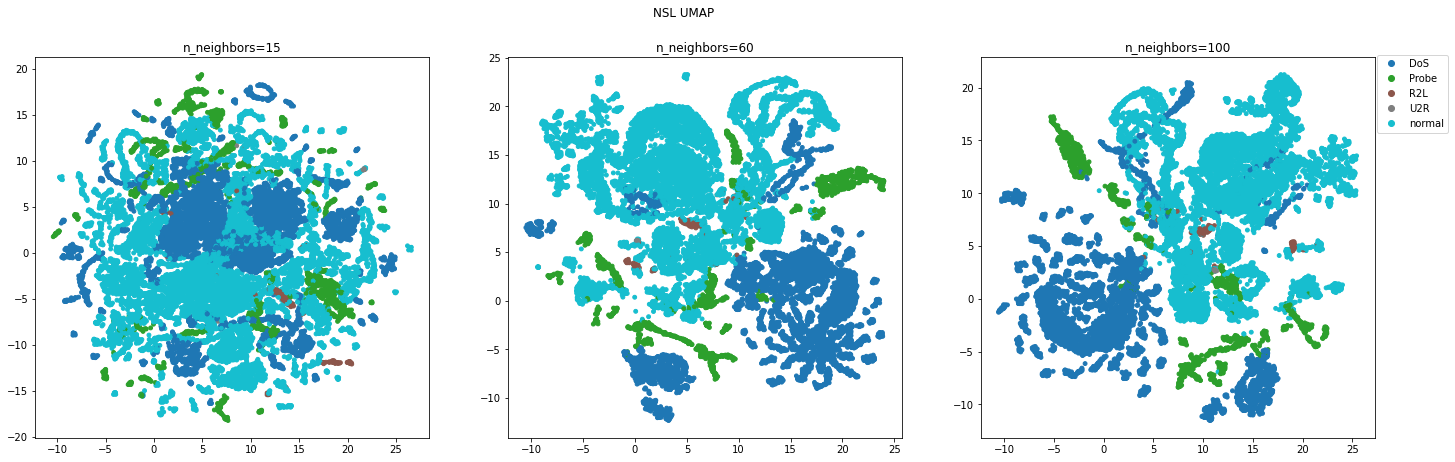

In [15]:
plot_2d(X_nsl_umap, nsl_lables[:20000], titles_umap_nsl, 'NSL UMAP', labels=attack_classes, bbox_shift=1.2, rows=1, figsize=(24, 7))

In [36]:
titles_umap_nsl = [
    'n_neighbors=15',
    'n_neighbors=60',
    'n_neighbors=100',
]

if RUN_ALGORITHMS:
    umap_list_nsl = [
        umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.6, random_state=42),
        umap.UMAP(n_neighbors=60, n_components=2, min_dist=0.6, random_state=42),
        umap.UMAP(n_neighbors=100, n_components=2, min_dist=0.6, random_state=42),
    ]

    X_nsl_umap = []
    for i, umap_model in enumerate(umap_list_nsl):
        print(f'Starting {titles_umap_nsl[i]}, ', end='')
        X_nsl_umap.append(run_and_measure(umap_model.fit_transform, X[:20000]))

    np.save(pwd + '/data/saved_X/X_nsl_umap_with_categorical_extracted_bn16_20000.npy', np.array(X_nsl_umap))

else:
    X_nsl_umap = np.load(pwd + '/data/saved_X/X_nsl_umap_with_categorical_extracted_bn16_20000.npy')

Starting n_neighbors=15, 16.52 s
Starting n_neighbors=60, 15.42 s
Starting n_neighbors=100, 18.51 s


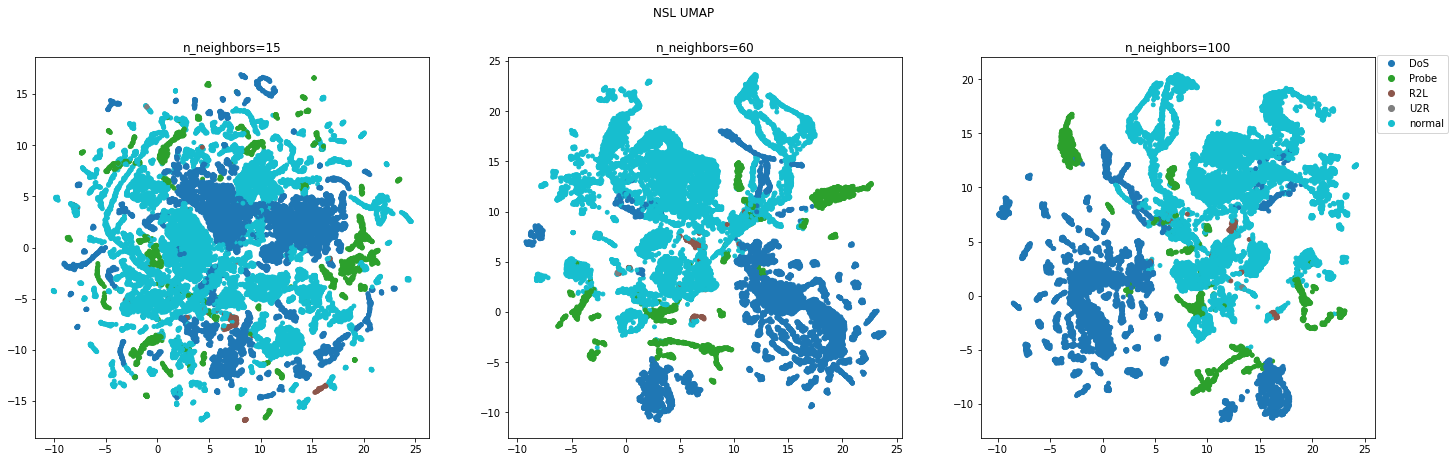

In [37]:
plot_2d(X_nsl_umap, nsl_lables[:20000], titles_umap_nsl, 'NSL UMAP', labels=attack_classes, bbox_shift=1.2, rows=1, figsize=(24, 7))

In [38]:
titles_umap_nsl = [
    'n_neighbors=15',
    'n_neighbors=60',
    'n_neighbors=100',
]

if RUN_ALGORITHMS:
    umap_list_nsl = [
        umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.8, random_state=42),
        umap.UMAP(n_neighbors=60, n_components=2, min_dist=0.8, random_state=42),
        umap.UMAP(n_neighbors=100, n_components=2, min_dist=0.8, random_state=42),
    ]

    X_nsl_umap = []
    for i, umap_model in enumerate(umap_list_nsl):
        print(f'Starting {titles_umap_nsl[i]}, ', end='')
        X_nsl_umap.append(run_and_measure(umap_model.fit_transform, X[:20000]))

    np.save(pwd + '/data/saved_X/X_nsl_umap_with_categorical_extracted_bn16_20000.npy', np.array(X_nsl_umap))

else:
    X_nsl_umap = np.load(pwd + '/data/saved_X/X_nsl_umap_with_categorical_extracted_bn16_20000.npy')

Starting n_neighbors=15, 13.84 s
Starting n_neighbors=60, 15.23 s
Starting n_neighbors=100, 18.66 s


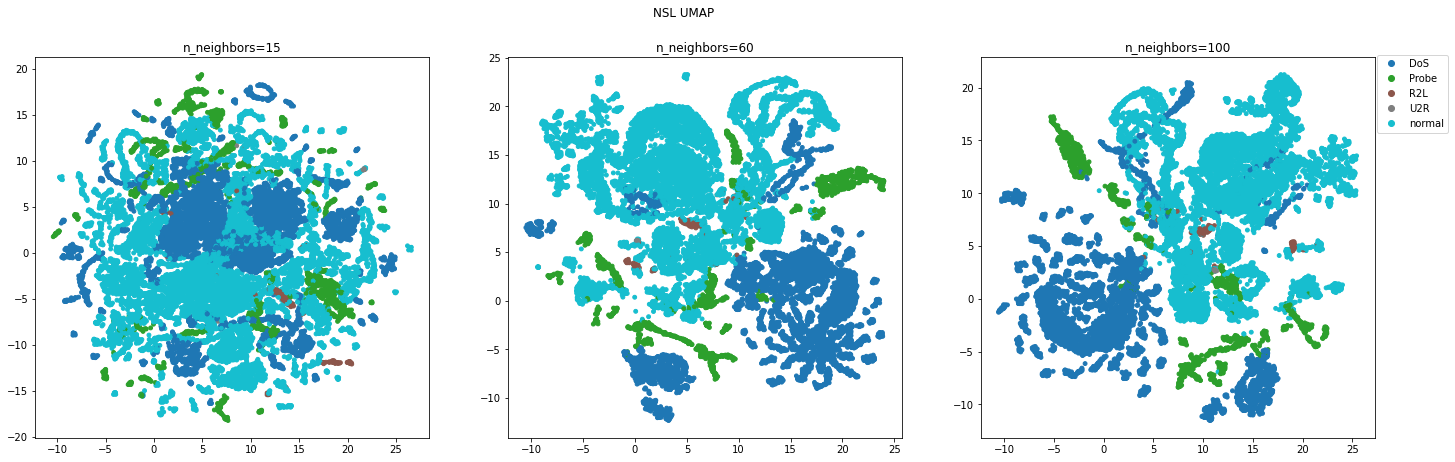

In [39]:
plot_2d(X_nsl_umap, nsl_lables[:20000], titles_umap_nsl, 'NSL UMAP', labels=attack_classes, bbox_shift=1.2, rows=1, figsize=(24, 7))

# Large Vis

In [19]:
perp = [25, 50, 75, 100, 140]
neigh = [x*3 for x in perp]

titles_largevis_nsl = [
    'perp=25 neigh=75',
    'perp=50 neigh=150',
    'perp=75 neigh=225',
    'perp=100 neigh=300',
    'perp=140 neigh=420'
]
path = pwd + "/data/points/nsl_points_with_categorical_extracted_bn16.txt"

In [20]:
if RUN_ALGORITHMS:
    write_to_file(X, path)
    X_nsl_largevis = []
    for p,n in zip(perp, neigh):
        !{pwd}/LargeVis -input {pwd}/data/points/nsl_points_with_categorical_extracted_bn16.txt -perp $p -neigh $n -output {pwd}/data/after_largevis/after_largevis_with_categorical_extracted_bn16_nsl_$p\_$n\.txt
        df = pd.read_csv(pwd + f"/data/after_largevis/after_largevis_with_categorical_extracted_bn16_nsl_{p}_{n}.txt", sep=' ', header=None)
        X_nsl_largevis.append(df.values[1:])
    np.save(pwd + '/data/saved_X/X_nsl_with_categorical_extracted_bn16_largevis.npy', np.array(X_nsl_largevis))
else:
    X_nsl_largevis = np.load(pwd + '/data/saved_X/X_nsl_with_categorical_extracted_bn16_largevis.npy')

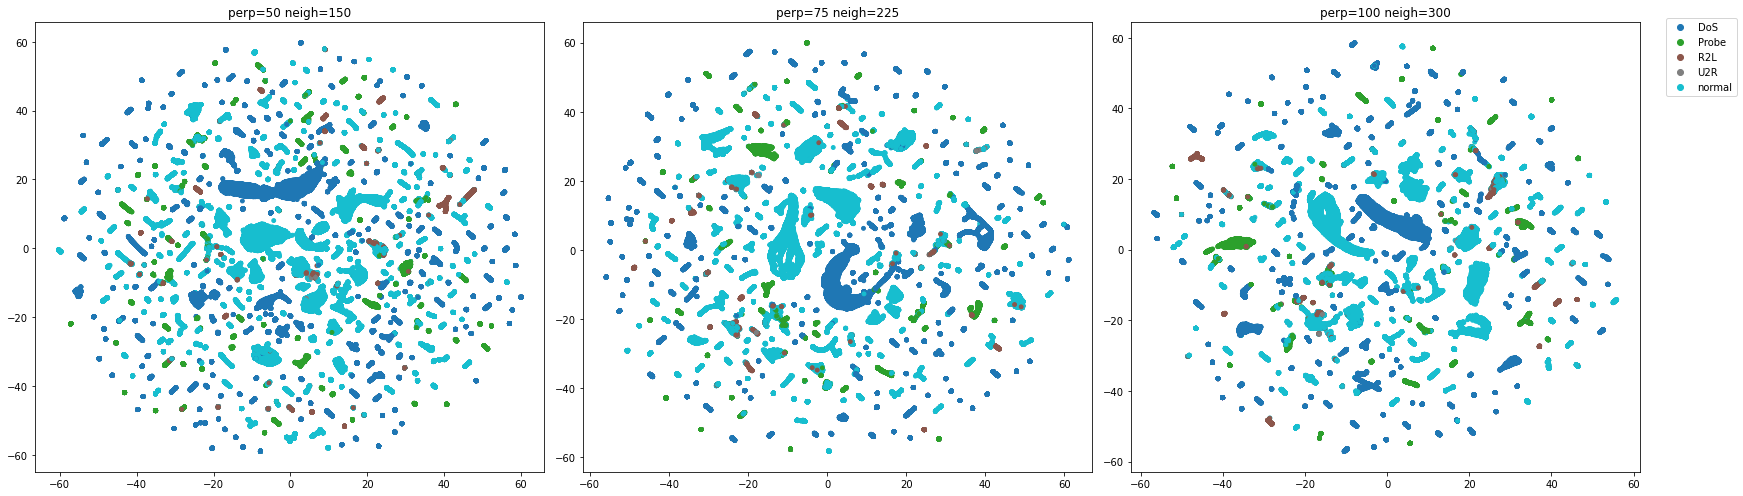

In [21]:
plot_2d(X_nsl_largevis[1:4], nsl_lables, titles_largevis_nsl[1:4], 'NSL LargeVis', labels=attack_classes, bbox_shift=1.2, rows=1, figsize=(24, 7))